Broj duplih redaka prije brisanja: 125
Broj duplih redaka nakon brisanja: 0
Novi broj redaka: 12205

Nedostajuće vrijednosti po stupcima (samo >0):
Series([], dtype: int64)

Ukupno NaN u cijelom df: 0

Oblici (klasifikacija):
X_train: (9764, 16) X_test: (2441, 16)
Udio klase 1 (train/test): 0.1563 / 0.1565

Nakon one-hot encodinga:
X_train: (9764, 66) X_test: (2441, 66)
NaN u train: 0
NaN u test : 0

Finalno spremno:
X_train_enc   : (9764, 66)  (za tree/naive Bayes itd.)
X_train_scaled: (9764, 66)  (za logističku regresiju itd.)

Oblici (regresija):
X_train: (9764, 16) X_test: (2441, 16)

--- Top 10 varijabli koje NAJVIŠE smanjuju šansu za Revenue=1 (OR najmanji) ---
                    coef        OR
ExitRates      -1.475031  0.228772
Month_Feb      -1.225376  0.293647
TrafficType_15 -0.867639  0.419942
Browser_7      -0.826901  0.437403
Browser_3      -0.818204  0.441223
Month_Mar      -0.537717  0.584080
TrafficType_18 -0.516091  0.596849
TrafficType_13 -0.454919  0.634499
Month_Dec

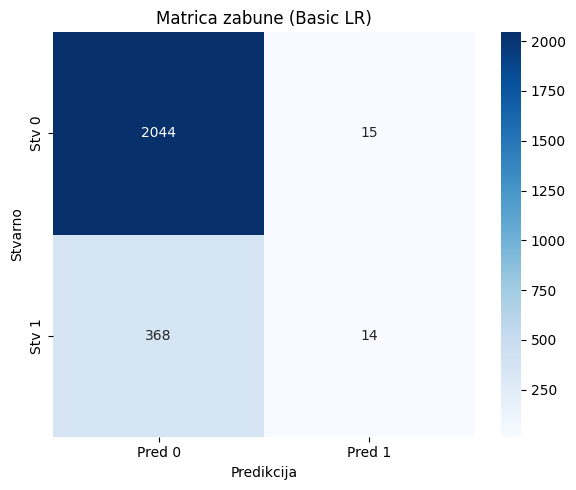

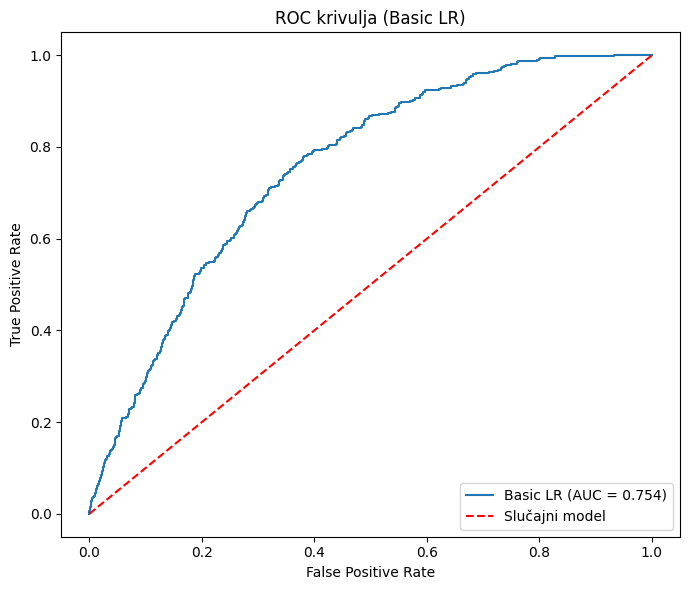

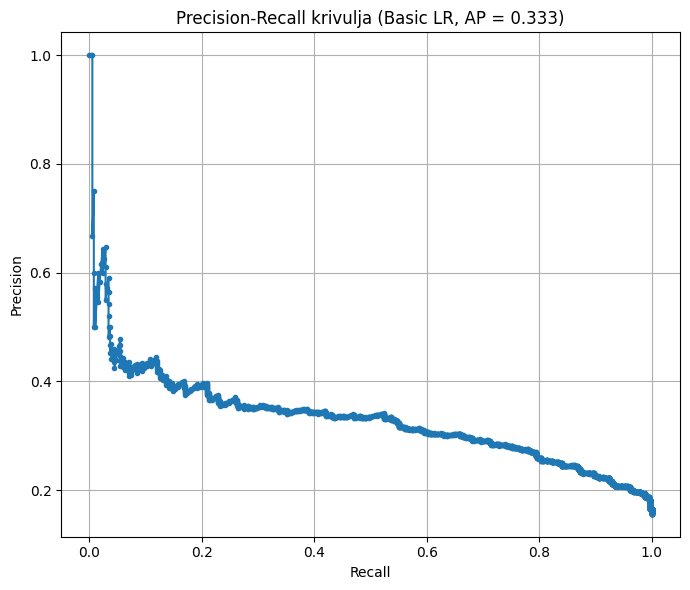


Najbolji hiperparametri (Best LR): {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
Najbolji CV score (F1): 0.3897

=== BEST LR (test) ===
Accuracy: 0.6489
ROC AUC : 0.7557
PR AUC  : 0.3312

Classification report (Best LR):
              precision    recall  f1-score   support

           0     0.9393    0.6241    0.7499      2059
           1     0.2787    0.7827    0.4110       382

    accuracy                         0.6489      2441
   macro avg     0.6090    0.7034    0.5805      2441
weighted avg     0.8359    0.6489    0.6969      2441


Matrica zabune (Best LR):
            Predviđeno 0  Predviđeno 1
Stvarno 0          1285           774
Stvarno 1            83           299


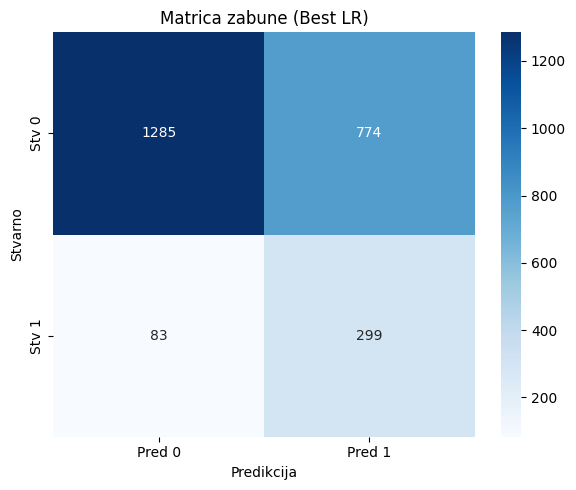

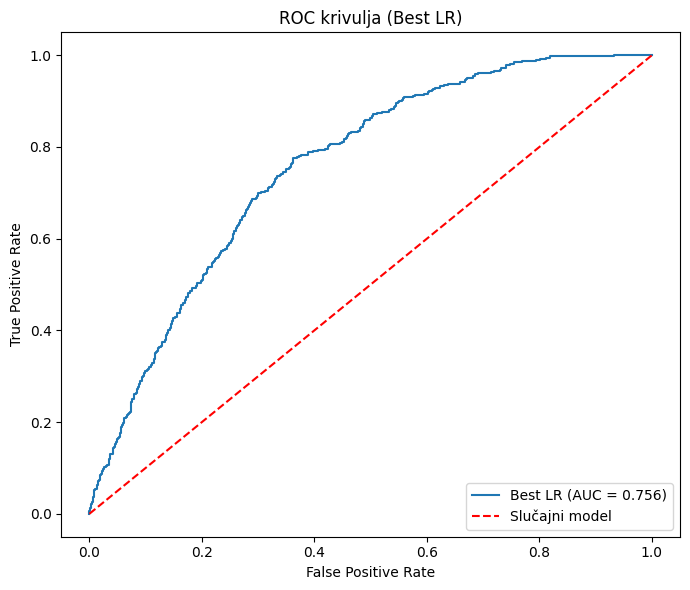

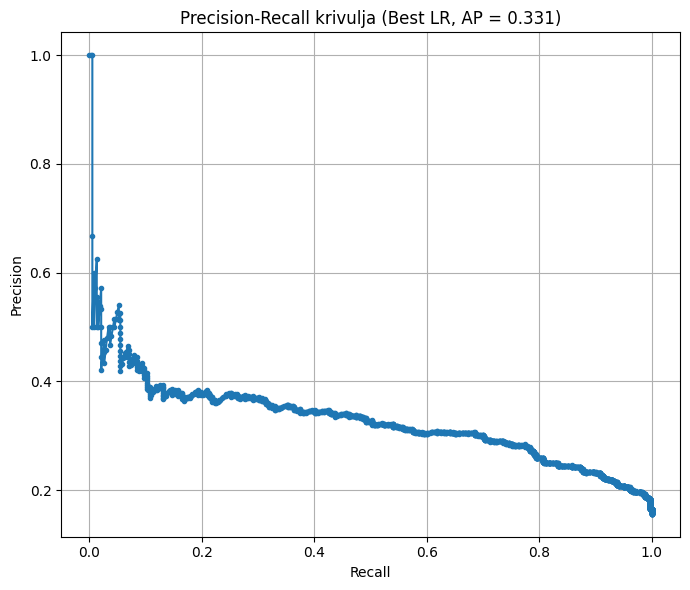

In [8]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

df = pd.read_csv("online_shoppers_intention.csv")

print("Broj duplih redaka prije brisanja:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("Broj duplih redaka nakon brisanja:", df.duplicated().sum())
print("Novi broj redaka:", len(df))

missing = df.isna().sum().sort_values(ascending=False)
print("\nNedostajuće vrijednosti po stupcima (samo >0):")
print(missing[missing > 0])
print("\nUkupno NaN u cijelom df:", int(df.isna().sum().sum()))

X_cls = df.drop(columns=["Revenue", "PageValues"])
y_cls = df["Revenue"].astype(int)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls,
    test_size=0.20,
    random_state=42,
    stratify=y_cls
)

print("\nOblici (klasifikacija):")
print("X_train:", X_train_cls.shape, "X_test:", X_test_cls.shape)
print("Udio klase 1 (train/test):",
      y_train_cls.mean().round(4), "/", y_test_cls.mean().round(4))

categorical_cols = [
    "Month",
    "VisitorType",
    "Weekend",
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType"
]
categorical_cols = [c for c in categorical_cols if c in X_train_cls.columns]

DROP_FIRST = True

scale_cols = [c for c in X_train_cls.columns if c not in categorical_cols]

X_train_enc = pd.get_dummies(
    X_train_cls, columns=categorical_cols, drop_first=DROP_FIRST, dtype=int
)
X_test_enc = pd.get_dummies(
    X_test_cls, columns=categorical_cols, drop_first=DROP_FIRST, dtype=int
)

X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("\nNakon one-hot encodinga:")
print("X_train:", X_train_enc.shape, "X_test:", X_test_enc.shape)
print("NaN u train:", int(X_train_enc.isna().sum().sum()))
print("NaN u test :", int(X_test_enc.isna().sum().sum()))


scaler = StandardScaler()

X_train_scaled = X_train_enc.copy()
X_test_scaled = X_test_enc.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train_enc[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test_enc[scale_cols])

print("\nFinalno spremno:")
print("X_train_enc   :", X_train_enc.shape, " (za tree/naive Bayes itd.)")
print("X_train_scaled:", X_train_scaled.shape, " (za logističku regresiju itd.)")

X_reg = df.drop(columns=["PageValues", "Revenue"])
y_reg = df["PageValues"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=0.20,
    random_state=42
)

print("\nOblici (regresija):")
print("X_train:", X_train_reg.shape, "X_test:", X_test_reg.shape)


log_reg = LogisticRegression(
    random_state=42,
    max_iter=2000,
    solver="liblinear"
)

log_reg.fit(X_train_scaled, y_train_cls)

coef = pd.Series(log_reg.coef_[0], index=X_train_scaled.columns).sort_values()
odds_ratio = np.exp(coef)

print("\n--- Top 10 varijabli koje NAJVIŠE smanjuju šansu za Revenue=1 (OR najmanji) ---")
print(pd.DataFrame({"coef": coef.head(10), "OR": odds_ratio.head(10)}))

print("\n--- Top 10 varijabli koje NAJVIŠE povećavaju šansu za Revenue=1 (OR najveći) ---")
print(pd.DataFrame({"coef": coef.tail(10), "OR": odds_ratio.tail(10)}))

print("\nIntercept:", log_reg.intercept_[0], " | exp(intercept):", np.exp(log_reg.intercept_[0]))

y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test_cls, y_pred)
roc_auc = roc_auc_score(y_test_cls, y_proba)
pr_auc = average_precision_score(y_test_cls, y_proba)

print("\n=== BASIC LR (test) ===")
print("Accuracy:", f"{acc:.4f}")
print("ROC AUC :", f"{roc_auc:.4f}")
print("PR AUC  :", f"{pr_auc:.4f}")
print("\nClassification report (Basic LR):")
print(classification_report(y_test_cls, y_pred, digits=4))

cm = confusion_matrix(y_test_cls, y_pred)
cm_df = pd.DataFrame(cm, index=["Stvarno 0", "Stvarno 1"], columns=["Predviđeno 0", "Predviđeno 1"])
print("\nMatrica zabune (Basic LR):\n", cm_df)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Stv 0", "Stv 1"])
plt.title("Matrica zabune (Basic LR)")
plt.xlabel("Predikcija")
plt.ylabel("Stvarno")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test_cls, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Basic LR (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "r--", label="Slučajni model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivulja (Basic LR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_cls, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall krivulja (Basic LR, AP = {pr_auc:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}

base_lr = LogisticRegression(
    random_state=42,
    max_iter=3000,
    solver="liblinear"
)

grid = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train_cls)

print("\nNajbolji hiperparametri (Best LR):", grid.best_params_)
print("Najbolji CV score (F1):", f"{grid.best_score_:.4f}")

best_lr = grid.best_estimator_


y_pred_best = best_lr.predict(X_test_scaled)
y_proba_best = best_lr.predict_proba(X_test_scaled)[:, 1]

acc_best = accuracy_score(y_test_cls, y_pred_best)
roc_auc_best = roc_auc_score(y_test_cls, y_proba_best)
pr_auc_best = average_precision_score(y_test_cls, y_proba_best)

print("\n=== BEST LR (test) ===")
print("Accuracy:", f"{acc_best:.4f}")
print("ROC AUC :", f"{roc_auc_best:.4f}")
print("PR AUC  :", f"{pr_auc_best:.4f}")
print("\nClassification report (Best LR):")
print(classification_report(y_test_cls, y_pred_best, digits=4))


cm_best = confusion_matrix(y_test_cls, y_pred_best)
cm_best_df = pd.DataFrame(cm_best, index=["Stvarno 0", "Stvarno 1"], columns=["Predviđeno 0", "Predviđeno 1"])
print("\nMatrica zabune (Best LR):\n", cm_best_df)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Stv 0", "Stv 1"])
plt.title("Matrica zabune (Best LR)")
plt.xlabel("Predikcija")
plt.ylabel("Stvarno")
plt.tight_layout()
plt.show()


fpr_b, tpr_b, _ = roc_curve(y_test_cls, y_proba_best)
plt.figure(figsize=(7, 6))
plt.plot(fpr_b, tpr_b, label=f"Best LR (AUC = {roc_auc_best:.3f})")
plt.plot([0, 1], [0, 1], "r--", label="Slučajni model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivulja (Best LR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


prec_b, rec_b, _ = precision_recall_curve(y_test_cls, y_proba_best)
plt.figure(figsize=(7, 6))
plt.plot(rec_b, prec_b, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall krivulja (Best LR, AP = {pr_auc_best:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()


REGRESIJSKO MODELIRANJE - Predviđanje PageValues

Početni broj redaka: 12330
Broj stupaca: 18

Broj duplikata prije brisanja: 125
Broj duplikata nakon brisanja: 0
Broj redaka nakon čišćenja: 12205
Ukupno nedostajućih vrijednosti: 0

ANALIZA CILJNE VARIJABLE: PageValues
count    12205.000000
mean         5.949574
std         18.653671
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        361.763742
Name: PageValues, dtype: float64

Broj nul vrijednosti: 9475 (77.63%)
Broj nenul vrijednosti: 2730 (22.37%)

PRIPREMA PODATAKA
Ulazne varijable (X): (12205, 16)
Ciljna varijabla (y): (12205,)

Kategorijske varijable: ['Month', 'VisitorType']
Numeričke varijable: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']

Train set: 9764 uzoraka (80.0%)
Test set:  2441

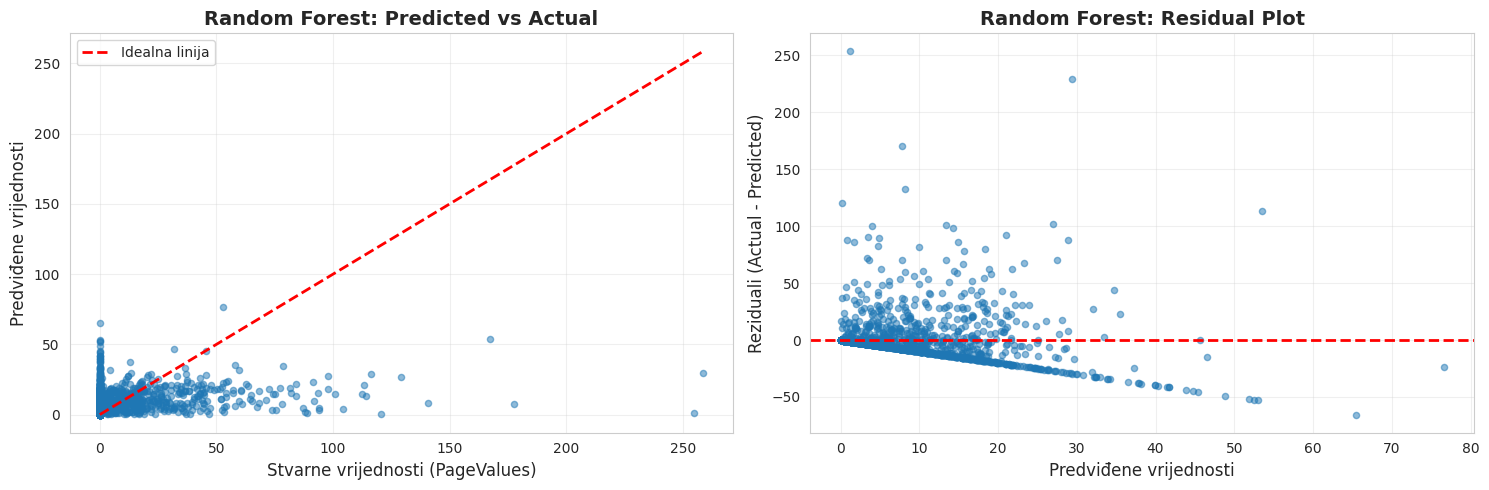

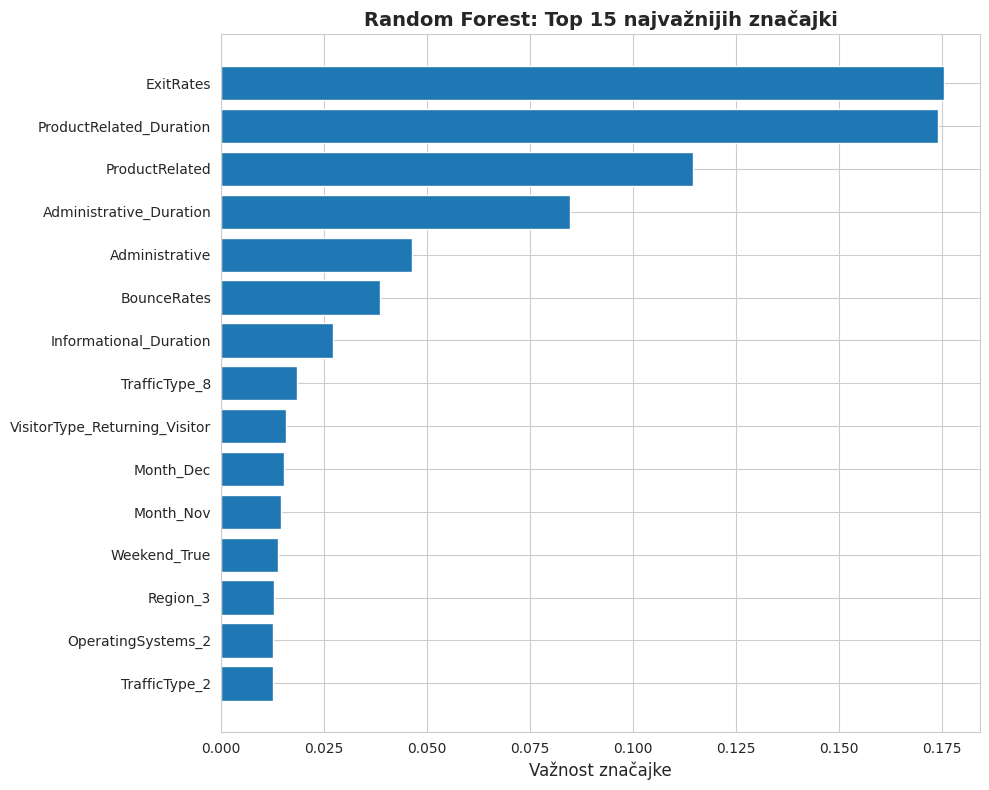


OPTIMIZACIJA HIPERPARAMETARA: RANDOM FOREST

Pokretanje GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Najbolji hiperparametri: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Najbolji CV score (neg MSE): -328.4934

EVALUACIJA: Random Forest (Optimized)
MAE (Mean Absolute Error):       7.6003
MSE (Mean Squared Error):        265.4432
RMSE (Root Mean Squared Error):  16.2924
R² Score:                        0.0886
MAPE (Mean Absolute % Error):    1.4898


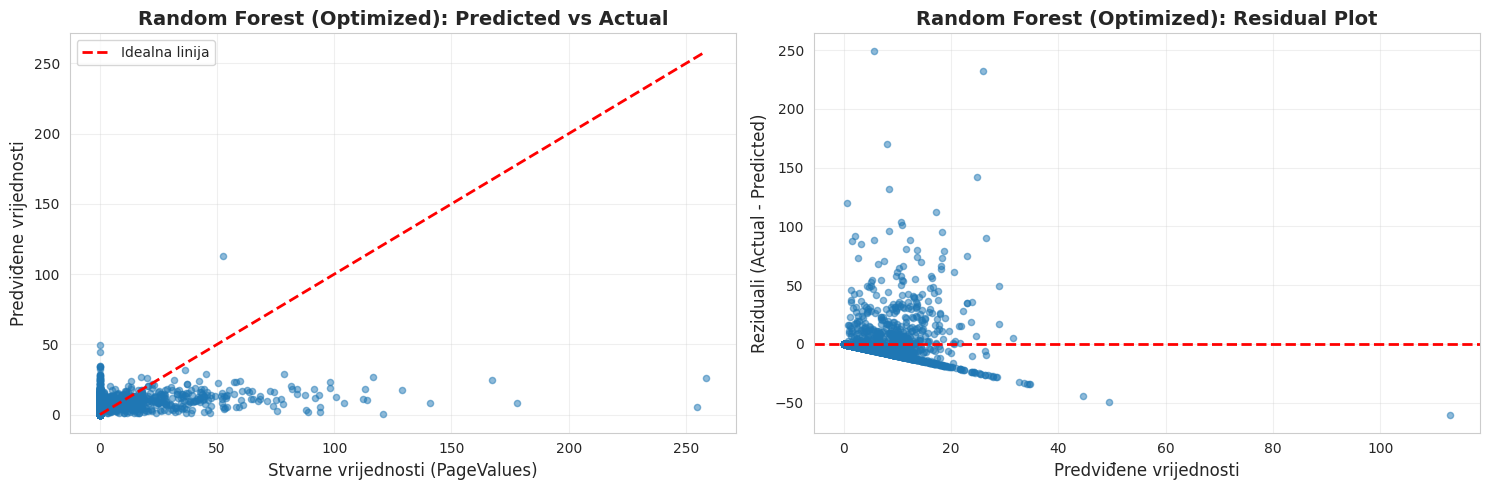


MODEL 2: XGBOOST REGRESSOR

Treniranje XGBoost modela...

--- TRAIN SET ---

EVALUACIJA: XGBoost (Train)
MAE (Mean Absolute Error):       6.3077
MSE (Mean Squared Error):        165.2904
RMSE (Root Mean Squared Error):  12.8565
R² Score:                        0.5434
MAPE (Mean Absolute % Error):    0.9878

--- TEST SET ---

EVALUACIJA: XGBoost (Test)
MAE (Mean Absolute Error):       7.5823
MSE (Mean Squared Error):        273.1224
RMSE (Root Mean Squared Error):  16.5264
R² Score:                        0.0622
MAPE (Mean Absolute % Error):    1.2756


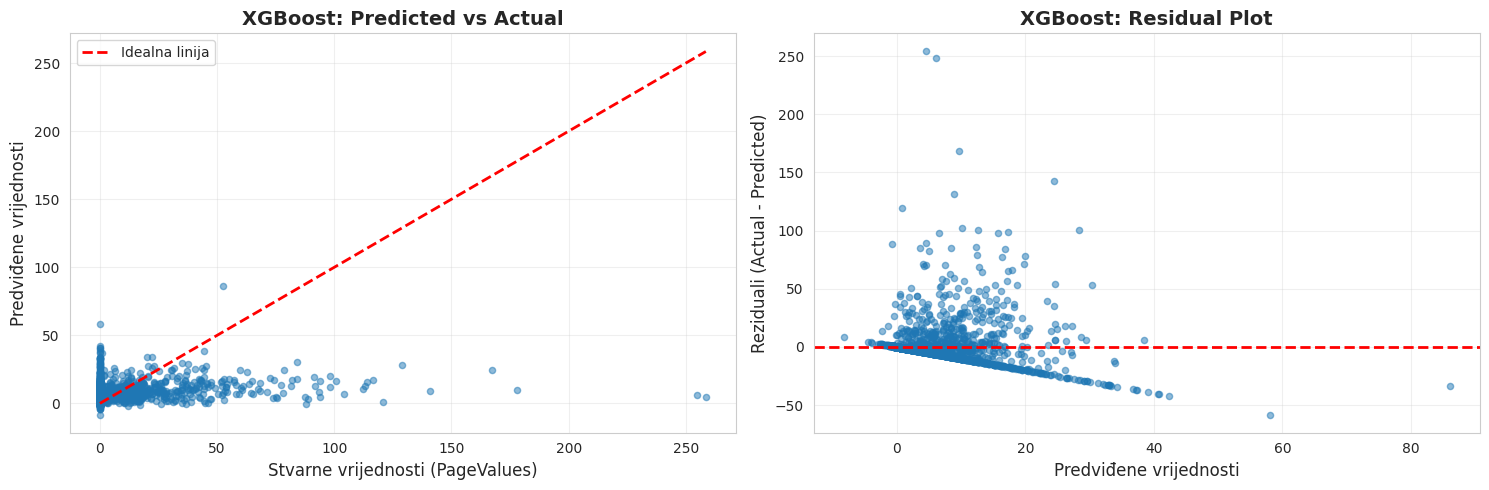

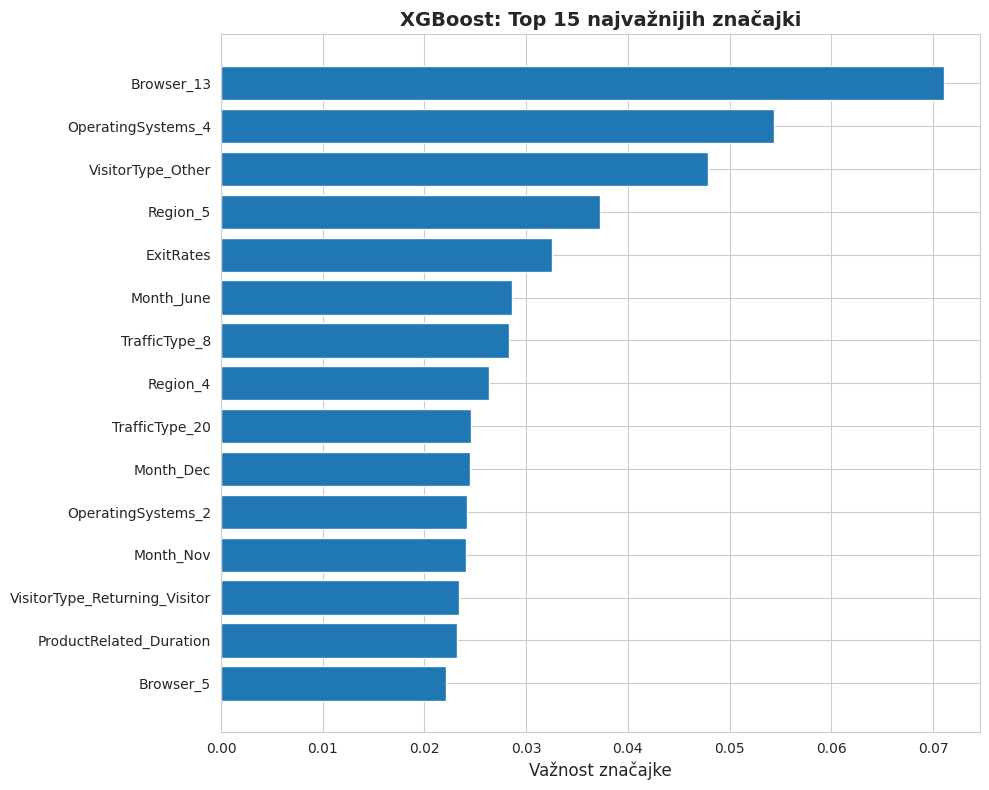


OPTIMIZACIJA HIPERPARAMETARA: XGBOOST

Pokretanje GridSearchCV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Najbolji hiperparametri: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Najbolji CV score (neg MSE): -325.7879

EVALUACIJA: XGBoost (Optimized)
MAE (Mean Absolute Error):       7.7131
MSE (Mean Squared Error):        262.3310
RMSE (Root Mean Squared Error):  16.1966
R² Score:                        0.0993
MAPE (Mean Absolute % Error):    1.3310


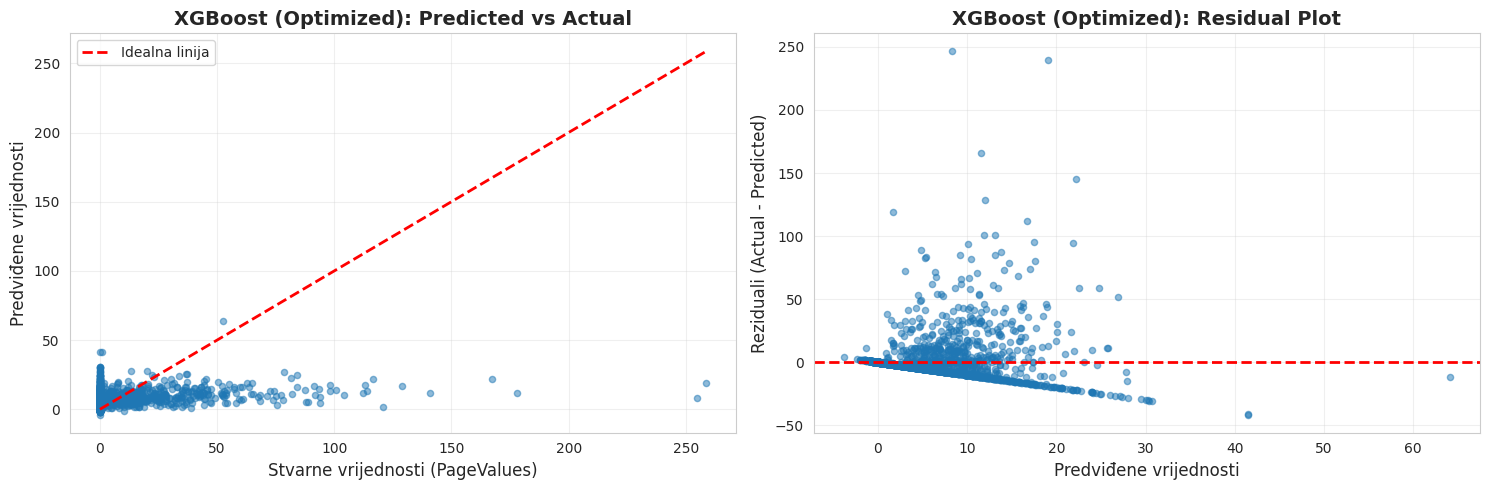


FINALNA USPOREDBA MODELA

                     Model      MAE        MSE      RMSE       R²     MAPE
     Random Forest (Test) 7.961441 278.842623 16.698581 0.042609 1.698798
Random Forest (Optimized) 7.600344 265.443221 16.292428 0.088616 1.489768
           XGBoost (Test) 7.582251 273.122397 16.526415 0.062250 1.275561
      XGBoost (Optimized) 7.713058 262.331024 16.196636 0.099301 1.331019


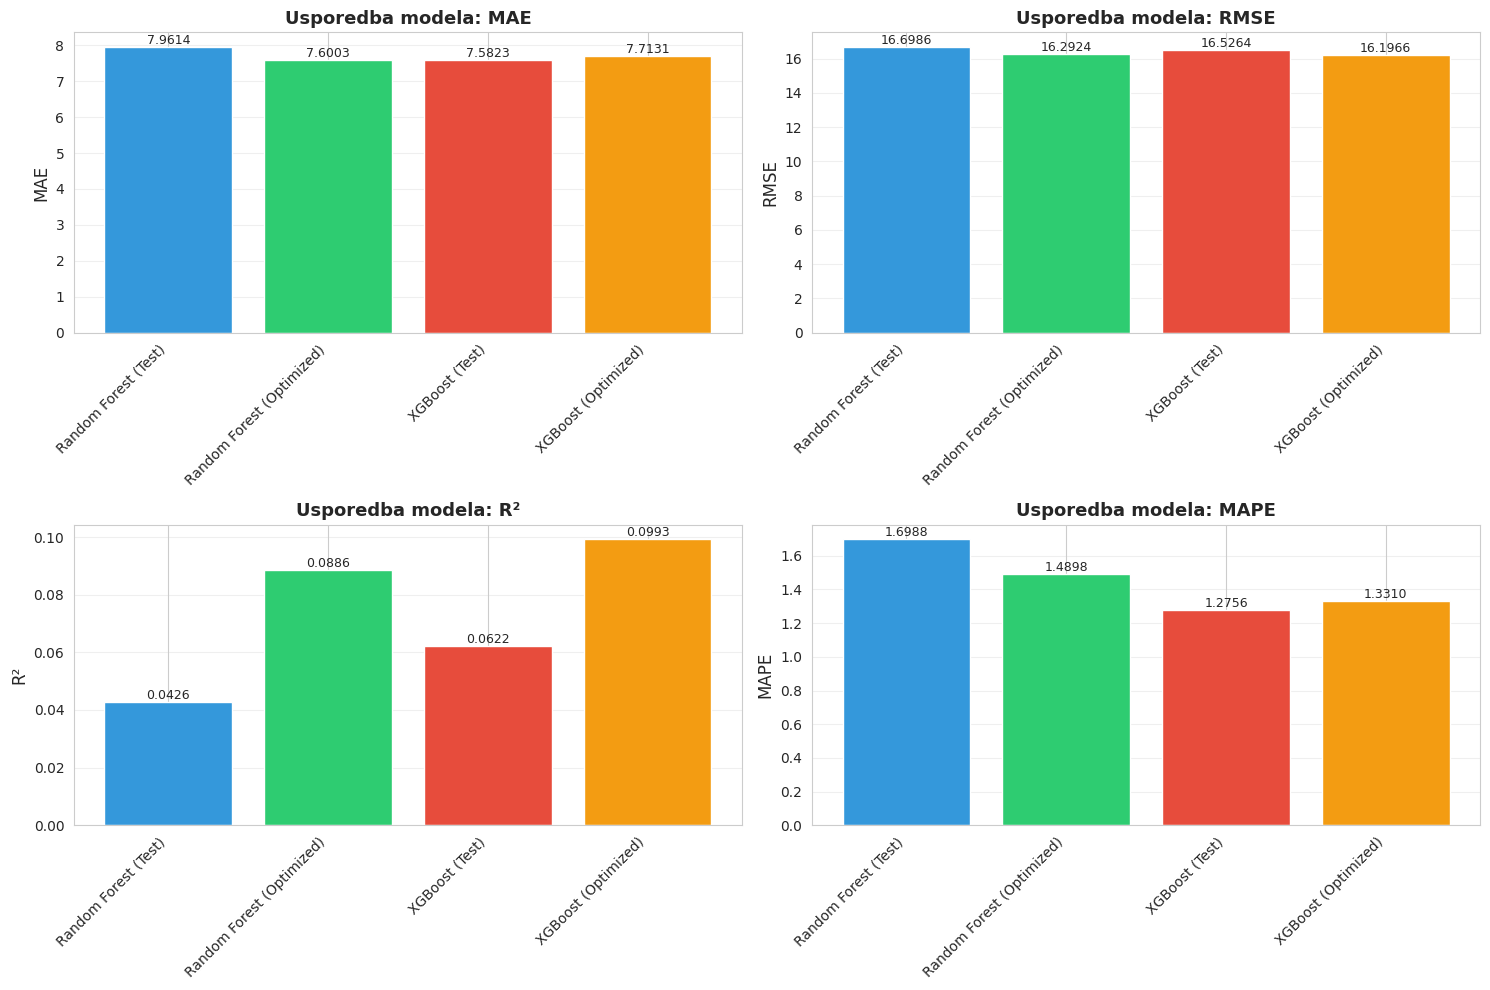


ANALIZA DISTRIBUCIJE GREŠAKA


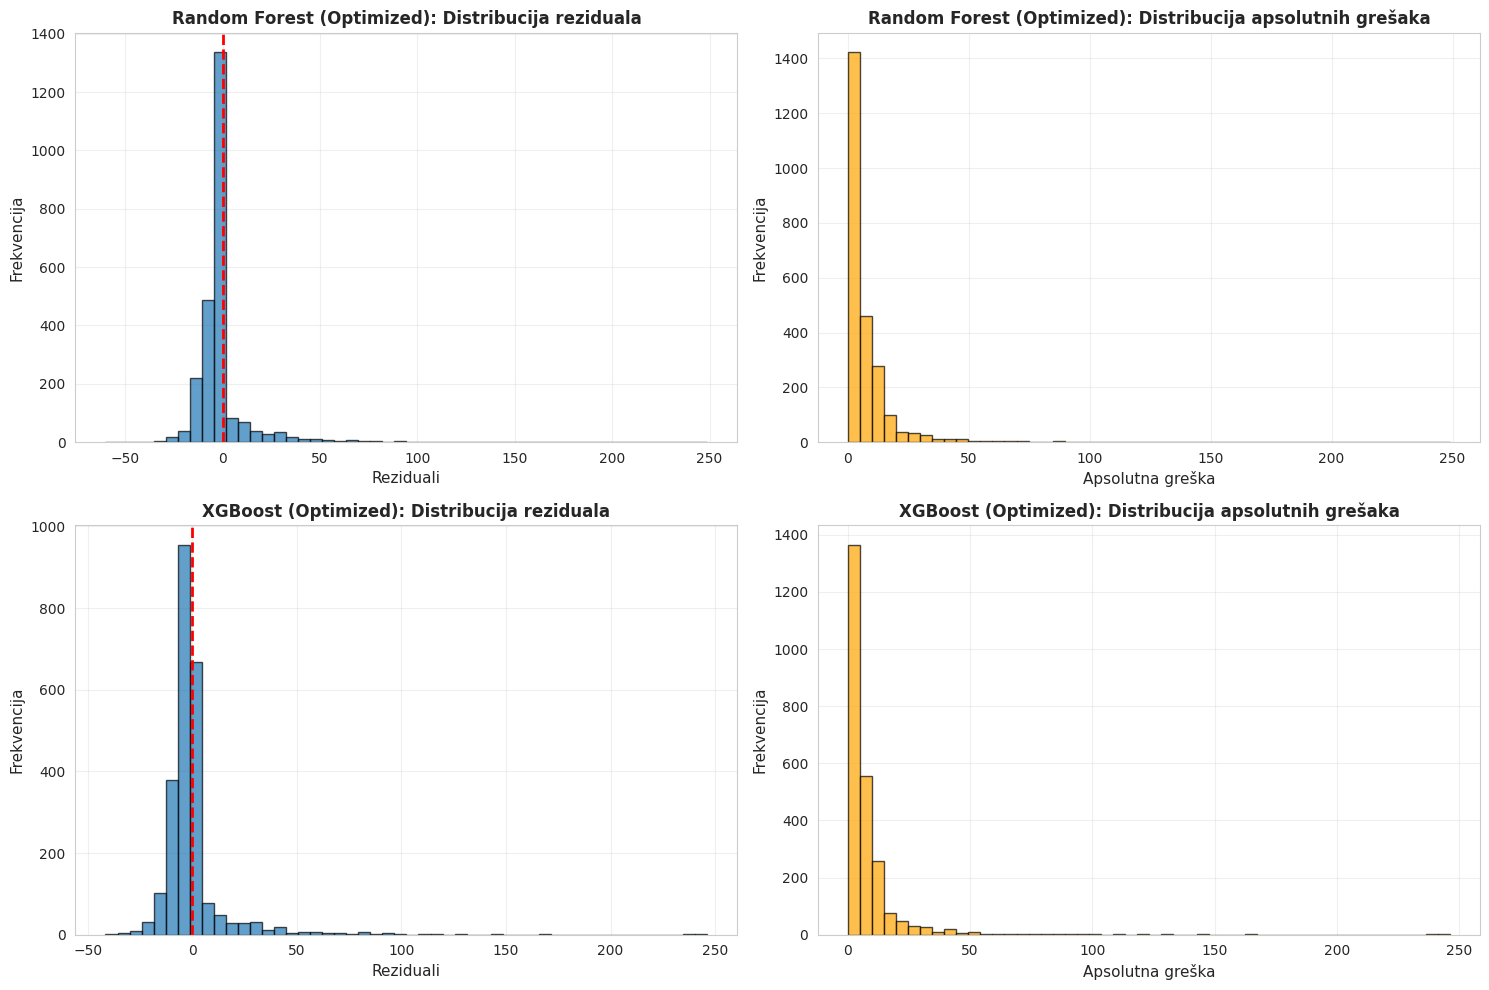


ZAKLJUČCI I PREPORUKE

 Najbolji model: XGBoost (Optimized)
  - R² Score: 0.0993
  - RMSE: 16.1966

KRAJ REGRESIJSKOG MODELIRANJA


In [12]:
# ============================================================
# REGRESIJSKO MODELIRANJE - PageValues
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
from xgboost import XGBRegressor

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv("online_shoppers_intention.csv")

print("=" * 70)
print("REGRESIJSKO MODELIRANJE - Predviđanje PageValues")
print("=" * 70)
print(f"\nPočetni broj redaka: {len(df)}")
print(f"Broj stupaca: {df.shape[1]}")

print(f"\nBroj duplikata prije brisanja: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print(f"Broj duplikata nakon brisanja: {df.duplicated().sum()}")
print(f"Broj redaka nakon čišćenja: {len(df)}")

missing = df.isna().sum().sum()
print(f"Ukupno nedostajućih vrijednosti: {missing}")

print("\n" + "=" * 70)
print("ANALIZA CILJNE VARIJABLE: PageValues")
print("=" * 70)
print(df['PageValues'].describe())
print(f"\nBroj nul vrijednosti: {(df['PageValues'] == 0).sum()} ({(df['PageValues'] == 0).sum() / len(df) * 100:.2f}%)")
print(f"Broj nenul vrijednosti: {(df['PageValues'] > 0).sum()} ({(df['PageValues'] > 0).sum() / len(df) * 100:.2f}%)")


X_reg = df.drop(columns=["PageValues", "Revenue"])
y_reg = df["PageValues"]

print("\n" + "=" * 70)
print("PRIPREMA PODATAKA")
print("=" * 70)
print(f"Ulazne varijable (X): {X_reg.shape}")
print(f"Ciljna varijabla (y): {y_reg.shape}")
print(f"\nKategorijske varijable: {X_reg.select_dtypes(include='object').columns.tolist()}")
print(f"Numeričke varijable: {X_reg.select_dtypes(exclude='object').columns.tolist()}")

X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg,
    test_size=0.20,
    random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} uzoraka ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]} uzoraka ({X_test.shape[0]/len(df)*100:.1f}%)")

categorical_cols = [
    "Month", "VisitorType", "Weekend",
    "OperatingSystems", "Browser", "Region", "TrafficType"
]
categorical_cols = [c for c in categorical_cols if c in X_train.columns]

print(f"\nKategorijske varijable za encoding: {categorical_cols}")

X_train_enc = pd.get_dummies(
    X_train,
    columns=categorical_cols,
    drop_first=True,
    dtype=int
)

X_test_enc = pd.get_dummies(
    X_test,
    columns=categorical_cols,
    drop_first=True,
    dtype=int
)

X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print(f"\nNakon encodinga:")
print(f"X_train: {X_train_enc.shape}")
print(f"X_test:  {X_test_enc.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

print(f"\nPodaci skalirani i spremni za treniranje")

def evaluate_regression_model(y_true, y_pred, model_name):
    """Izračunava i prikazuje metrike regresijskog modela"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    mask = y_true != 0
    if mask.sum() > 0:
        mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask])
    else:
        mape = np.nan

    print(f"\n{'=' * 70}")
    print(f"EVALUACIJA: {model_name}")
    print(f"{'=' * 70}")
    print(f"MAE (Mean Absolute Error):       {mae:.4f}")
    print(f"MSE (Mean Squared Error):        {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
    print(f"R² Score:                        {r2:.4f}")
    print(f"MAPE (Mean Absolute % Error):    {mape:.4f}" if not np.isnan(mape) else "MAPE: N/A")

    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

def plot_predictions(y_true, y_pred, model_name):
    """Crta Predicted vs Actual graf"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.scatter(y_true, y_pred, alpha=0.5, s=20)
    ax1.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2, label='Idealna linija')
    ax1.set_xlabel('Stvarne vrijednosti (PageValues)', fontsize=12)
    ax1.set_ylabel('Predviđene vrijednosti', fontsize=12)
    ax1.set_title(f'{model_name}: Predicted vs Actual', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    residuals = y_true - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5, s=20)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predviđene vrijednosti', fontsize=12)
    ax2.set_ylabel('Reziduali (Actual - Predicted)', fontsize=12)
    ax2.set_title(f'{model_name}: Residual Plot', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """Crta važnost značajki"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:]

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Važnost značajke', fontsize=12)
        plt.title(f'{model_name}: Top {top_n} najvažnijih značajki',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

print("\n" + "=" * 70)
print("MODEL 1: RANDOM FOREST REGRESSOR")
print("=" * 70)

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("\nTreniranje Random Forest modela...")
rf_model.fit(X_train_enc, y_train)

y_pred_rf_train = rf_model.predict(X_train_enc)
y_pred_rf_test = rf_model.predict(X_test_enc)

print("\n--- TRAIN SET ---")
rf_train_metrics = evaluate_regression_model(y_train, y_pred_rf_train, "Random Forest (Train)")

print("\n--- TEST SET ---")
rf_test_metrics = evaluate_regression_model(y_test, y_pred_rf_test, "Random Forest (Test)")

plot_predictions(y_test, y_pred_rf_test, "Random Forest")
plot_feature_importance(rf_model, X_train_enc.columns, "Random Forest", top_n=15)

print("\n" + "=" * 70)
print("OPTIMIZACIJA HIPERPARAMETARA: RANDOM FOREST")
print("=" * 70)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nPokretanje GridSearchCV...")
grid_rf.fit(X_train_enc, y_train)

print(f"\nNajbolji hiperparametri: {grid_rf.best_params_}")
print(f"Najbolji CV score (neg MSE): {grid_rf.best_score_:.4f}")

best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_enc)

rf_best_metrics = evaluate_regression_model(y_test, y_pred_best_rf, "Random Forest (Optimized)")

plot_predictions(y_test, y_pred_best_rf, "Random Forest (Optimized)")

print("\n" + "=" * 70)
print("MODEL 2: XGBOOST REGRESSOR")
print("=" * 70)

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

print("\nTreniranje XGBoost modela...")
xgb_model.fit(X_train_enc, y_train)

y_pred_xgb_train = xgb_model.predict(X_train_enc)
y_pred_xgb_test = xgb_model.predict(X_test_enc)

print("\n--- TRAIN SET ---")
xgb_train_metrics = evaluate_regression_model(y_train, y_pred_xgb_train, "XGBoost (Train)")

print("\n--- TEST SET ---")
xgb_test_metrics = evaluate_regression_model(y_test, y_pred_xgb_test, "XGBoost (Test)")

plot_predictions(y_test, y_pred_xgb_test, "XGBoost")
plot_feature_importance(xgb_model, X_train_enc.columns, "XGBoost", top_n=15)

print("\n" + "=" * 70)
print("OPTIMIZACIJA HIPERPARAMETARA: XGBOOST")
print("=" * 70)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nPokretanje GridSearchCV...")
grid_xgb.fit(X_train_enc, y_train)

print(f"\nNajbolji hiperparametri: {grid_xgb.best_params_}")
print(f"Najbolji CV score (neg MSE): {grid_xgb.best_score_:.4f}")

best_xgb = grid_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_enc)

xgb_best_metrics = evaluate_regression_model(y_test, y_pred_best_xgb, "XGBoost (Optimized)")

plot_predictions(y_test, y_pred_best_xgb, "XGBoost (Optimized)")

print("\n" + "=" * 70)
print("FINALNA USPOREDBA MODELA")
print("=" * 70)

results_df = pd.DataFrame([
    rf_test_metrics,
    rf_best_metrics,
    xgb_test_metrics,
    xgb_best_metrics
])

print("\n", results_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['MAE', 'RMSE', 'R²', 'MAPE']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    if metric in results_df.columns:
        values = results_df[metric].values
        models = results_df['Model'].values

        bars = ax.bar(range(len(models)), values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'Usporedba modela: {metric}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        for i, (bar, val) in enumerate(zip(bars, values)):
            if not np.isnan(val):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                       f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ANALIZA DISTRIBUCIJE GREŠAKA")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_to_analyze = [
    (y_pred_best_rf, "Random Forest (Optimized)"),
    (y_pred_best_xgb, "XGBoost (Optimized)")
]

for idx, (y_pred, model_name) in enumerate(models_to_analyze):
    ax1 = axes[idx, 0]
    residuals = y_test - y_pred
    ax1.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(x=0, color='r', linestyle='--', lw=2)
    ax1.set_xlabel('Reziduali', fontsize=11)
    ax1.set_ylabel('Frekvencija', fontsize=11)
    ax1.set_title(f'{model_name}: Distribucija reziduala', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[idx, 1]
    abs_errors = np.abs(residuals)
    ax2.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
    ax2.set_xlabel('Apsolutna greška', fontsize=11)
    ax2.set_ylabel('Frekvencija', fontsize=11)
    ax2.set_title(f'{model_name}: Distribucija apsolutnih grešaka', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("ZAKLJUČCI I PREPORUKE")
print("=" * 70)

best_model_idx = results_df['R²'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'R²']
best_rmse = results_df.loc[best_model_idx, 'RMSE']

print(f"\n Najbolji model: {best_model_name}")
print(f"  - R² Score: {best_r2:.4f}")
print(f"  - RMSE: {best_rmse:.4f}")

print("\n" + "=" * 70)
print("KRAJ REGRESIJSKOG MODELIRANJA")
print("=" * 70)



MODEL 3: GRADIENT BOOSTING REGRESSOR

Treniranje Gradient Boosting modela...

EVALUACIJA: Gradient Boosting (Test)
MAE (Mean Absolute Error):       7.7030
MSE (Mean Squared Error):        275.9379
RMSE (Root Mean Squared Error):  16.6114
R² Score:                        0.0526
MAPE (Mean Absolute % Error):    1.3820


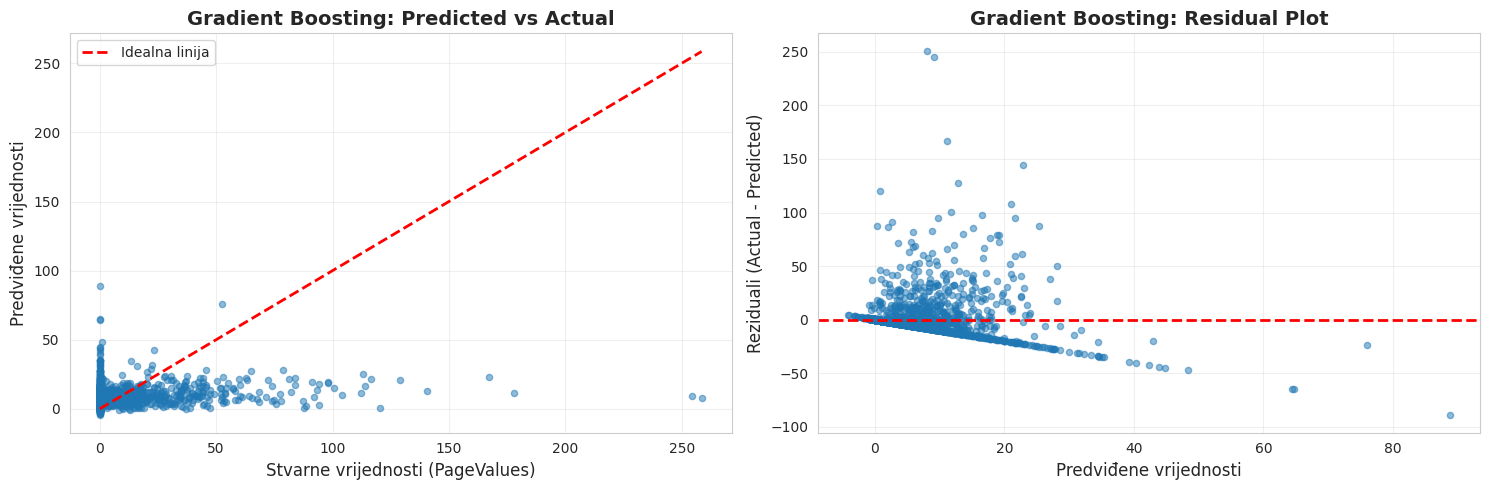

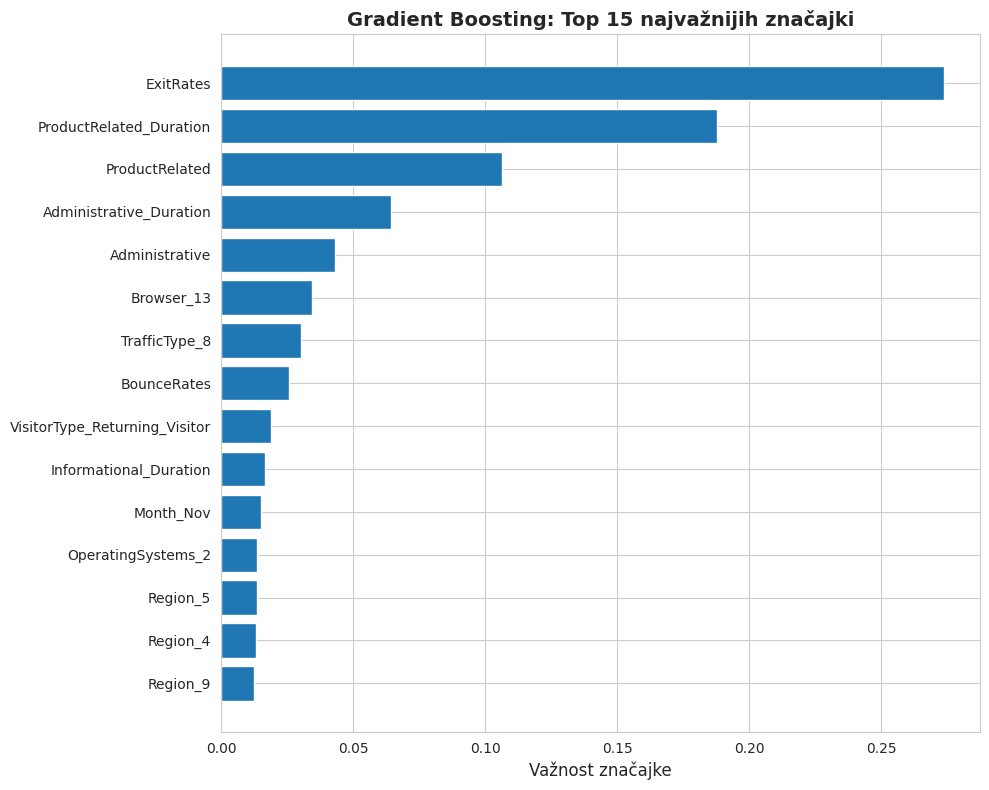


OPTIMIZACIJA: GRADIENT BOOSTING

Pokretanje GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Najbolji hiperparametri: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Najbolji CV score (neg MSE): -330.1489

EVALUACIJA: Gradient Boosting (Optimized)
MAE (Mean Absolute Error):       7.7325
MSE (Mean Squared Error):        265.5259
RMSE (Root Mean Squared Error):  16.2950
R² Score:                        0.0883
MAPE (Mean Absolute % Error):    1.3416

                         Model      MAE        MSE      RMSE       R²     MAPE
         Random Forest (Test) 7.961441 278.842623 16.698581 0.042609 1.698798
    Random Forest (Optimized) 7.600344 265.443221 16.292428 0.088616 1.489768
               XGBoost (Test) 7.582251 273.122397 16.526415 0.062250 1.275561
          XGBoost (Optimized) 7.713058 262.331024 16.196636 0.099301 1.331019
     Gradient Boosting (Test) 7.702974 275.937854 16.611377 0.052583 1.

In [13]:
print("\n" + "=" * 70)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("=" * 70)

from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

print("\nTreniranje Gradient Boosting modela...")
gb_model.fit(X_train_enc, y_train)

y_pred_gb_test = gb_model.predict(X_test_enc)

gb_test_metrics = evaluate_regression_model(y_test, y_pred_gb_test, "Gradient Boosting (Test)")

plot_predictions(y_test, y_pred_gb_test, "Gradient Boosting")
plot_feature_importance(gb_model, X_train_enc.columns, "Gradient Boosting", top_n=15)

print("\n" + "=" * 70)
print("OPTIMIZACIJA: GRADIENT BOOSTING")
print("=" * 70)

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

grid_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nPokretanje GridSearchCV...")
grid_gb.fit(X_train_enc, y_train)

print(f"\nNajbolji hiperparametri: {grid_gb.best_params_}")
print(f"Najbolji CV score (neg MSE): {grid_gb.best_score_:.4f}")

best_gb = grid_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test_enc)

gb_best_metrics = evaluate_regression_model(y_test, y_pred_best_gb, "Gradient Boosting (Optimized)")

results_df = pd.DataFrame([
    rf_test_metrics,
    rf_best_metrics,
    xgb_test_metrics,
    xgb_best_metrics,
    gb_test_metrics,
    gb_best_metrics
])

print("\n", results_df.to_string(index=False))



                     DETALJNI OPIS I USPOREDBA SVIH MODELA                      

--------------------------------------------------------------------------------
1. PREGLED SVIH TRENIRANIH MODELA
--------------------------------------------------------------------------------

Logistička Regresija (Basic):
  • Tip: Klasifikacija
  • Algoritam: Logistic Regression
  • Hiperparametri: Default (C=1.0, penalty='l2')
  • Skaliranje: Da (StandardScaler)
  • Namjena: Predviđanje Revenue (Da/Ne)

Logistička Regresija (Best):
  • Tip: Klasifikacija
  • Algoritam: Logistic Regression
  • Hiperparametri: Optimizirano GridSearchCV: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
  • Skaliranje: Da (StandardScaler)
  • Namjena: Predviđanje Revenue (Da/Ne)

Random Forest (Basic):
  • Tip: Regresija
  • Algoritam: Random Forest Regressor
  • Hiperparametri: n_estimators=100, default ostalo
  • Skaliranje: Ne
  • Namjena: Predviđanje PageValues

Random Forest (Optimized):
  • Tip: Regresija
  

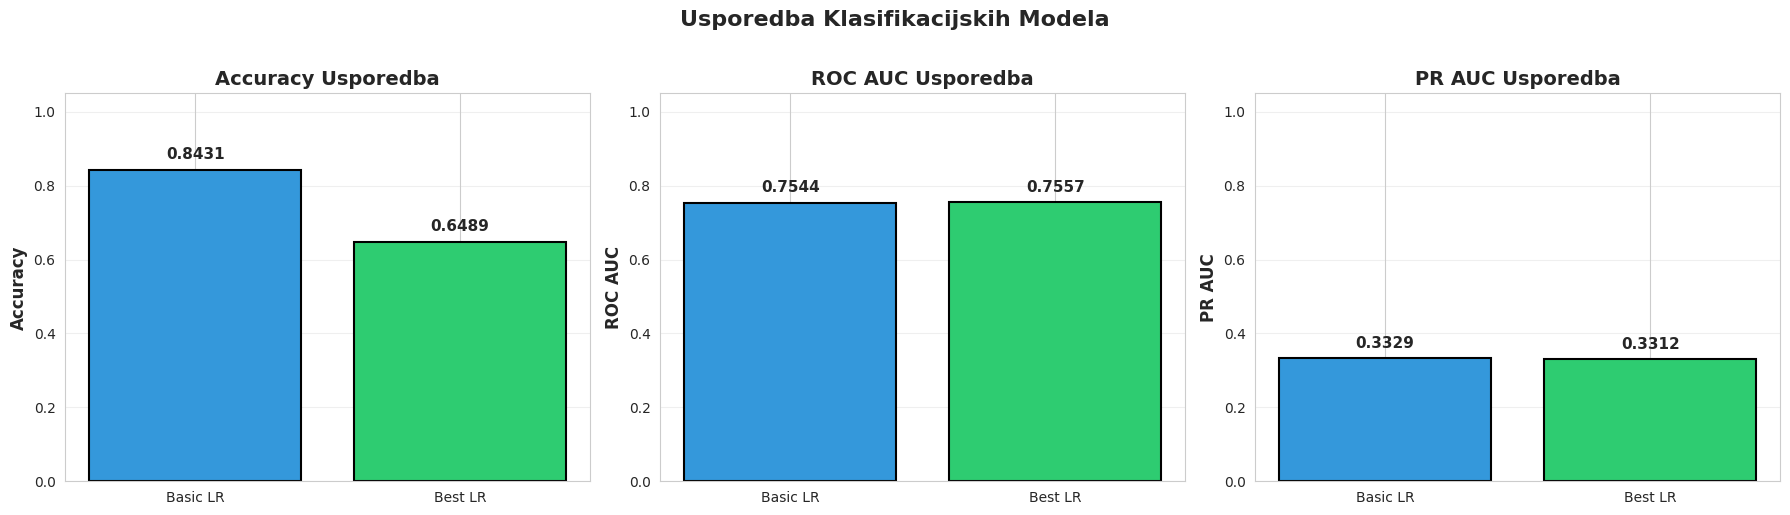


3. USPOREDBA REGRESIJSKIH MODELA (Predviđanje PageValues)

                         Model      MAE        MSE      RMSE       R²     MAPE
         Random Forest (Test) 7.961441 278.842623 16.698581 0.042609 1.698798
    Random Forest (Optimized) 7.600344 265.443221 16.292428 0.088616 1.489768
               XGBoost (Test) 7.582251 273.122397 16.526415 0.062250 1.275561
          XGBoost (Optimized) 7.713058 262.331024 16.196636 0.099301 1.331019
     Gradient Boosting (Test) 7.702974 275.937854 16.611377 0.052583 1.381967
Gradient Boosting (Optimized) 7.732519 265.525916 16.294966 0.088332 1.341571

--------------------------------------------------------------------------------
RANGIRANJE MODELA PO R² SCORE:
--------------------------------------------------------------------------------

                               Model        R²       RMSE       MAE
Rang                                                              
1               XGBoost (Optimized)  0.099301  16.196636  7.713

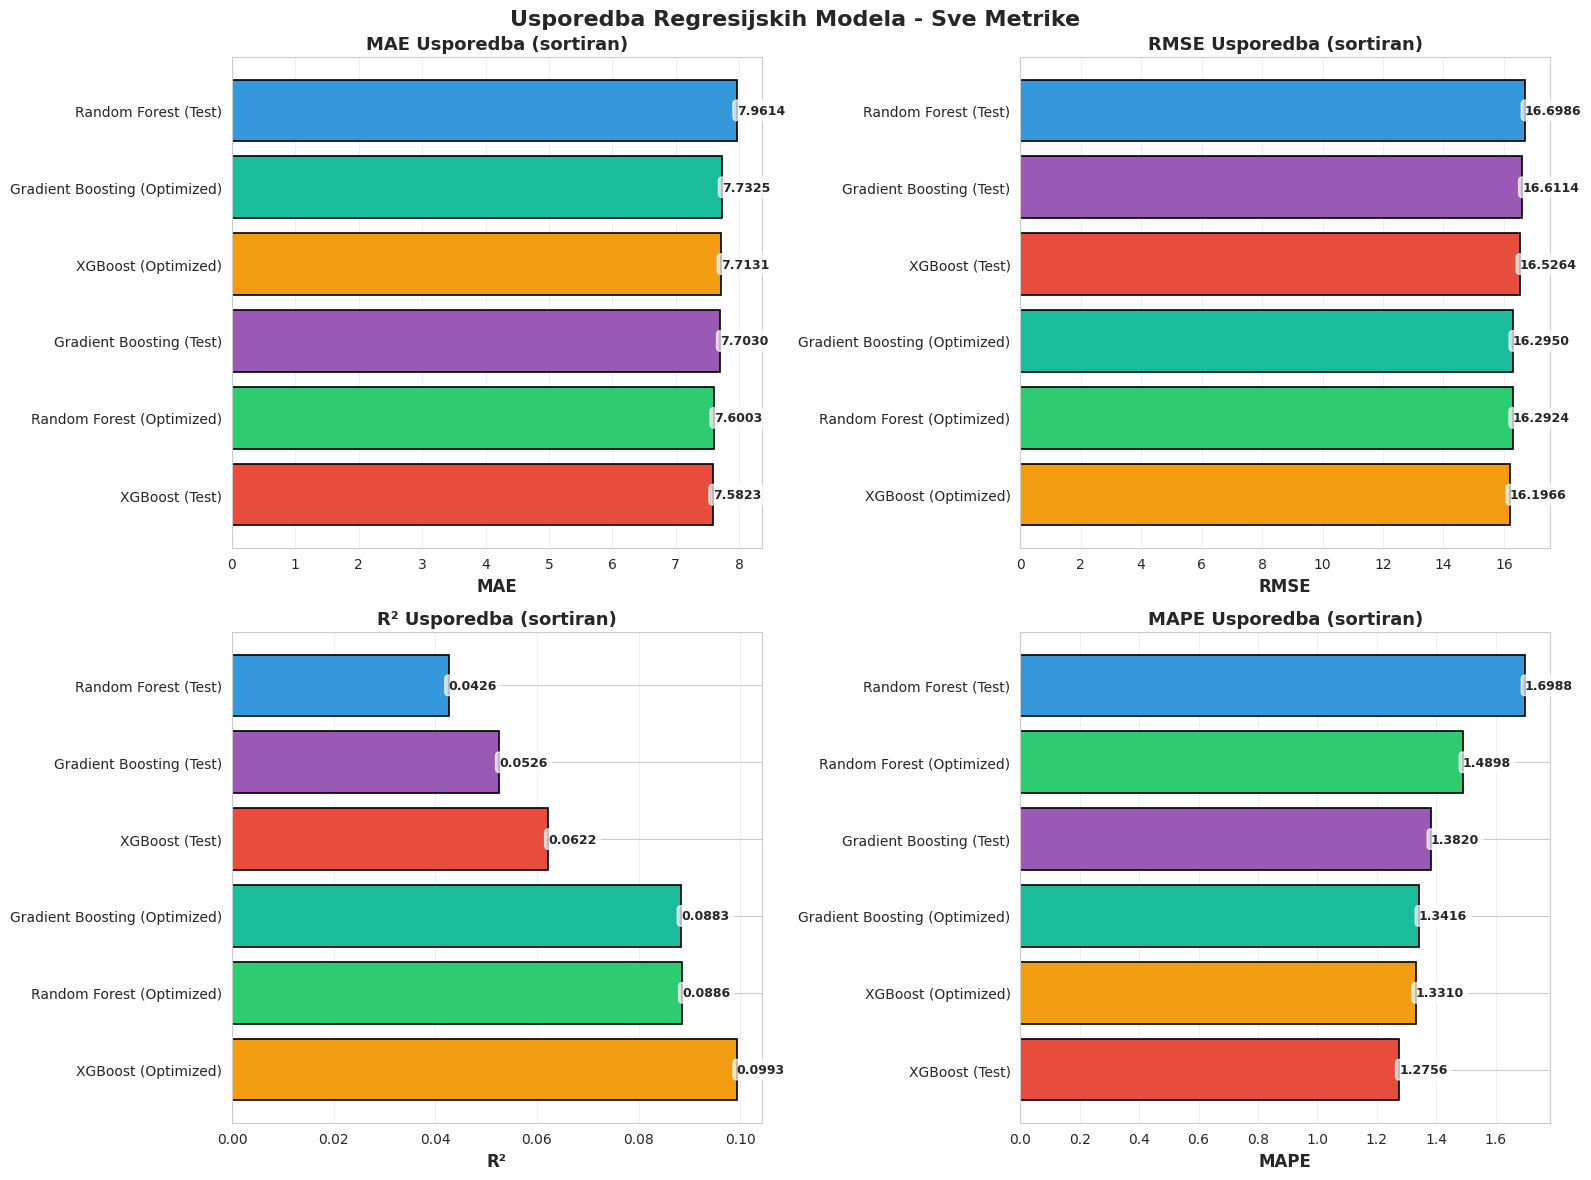


4. ANALIZA POBOLJŠANJA NAKON OPTIMIZACIJE

             Model  R² Before  R² After  RMSE Before  RMSE After  R² Improvement  RMSE Improvement  R² Improvement %  RMSE Improvement %
    Random Forest   0.042609  0.088616    16.698581   16.292428        0.046006          0.406153        107.971551            2.432261
          XGBoost   0.062250  0.099301    16.526415   16.196636        0.037052          0.329779         59.521048            1.995466
Gradient Boosting   0.052583  0.088332    16.611377   16.294966        0.035749          0.316411         67.985703            1.904786


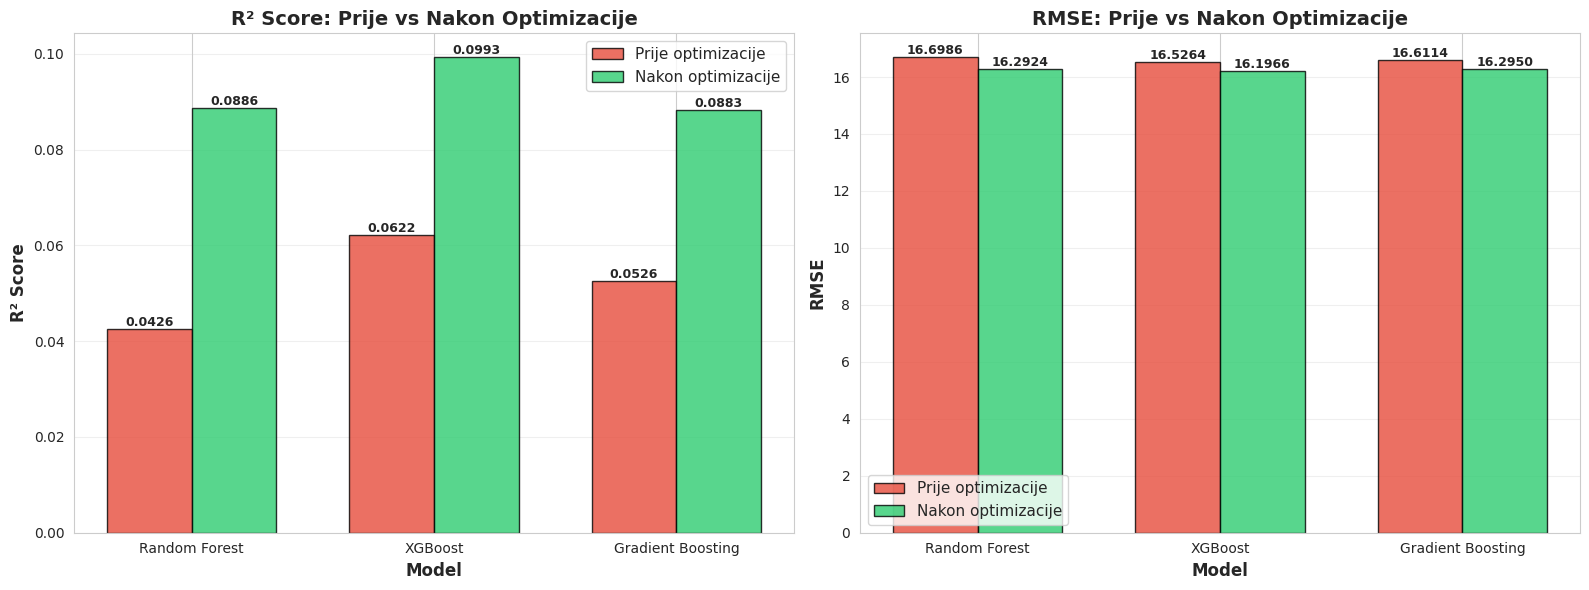


5. NAJBOLJI MODELI I PREPORUKE

✓ NAJBOLJI KLASIFIKACIJSKI MODEL: Basic LR
  • Accuracy: 0.8431
  • ROC AUC: 0.7557
  • PR AUC: 0.3329

✓ NAJBOLJI REGRESIJSKI MODEL: XGBoost (Optimized)
  • R² Score: 0.0993
  • RMSE: 16.1966
  • MAE: 7.7131

7. FINALNA TABLICA - SVE METRIKE SVH MODELA

                         Model           Tip Glavna metrika Dodatna metrika
                     Basic LR Klasifikacija   0.8431 (Acc)    0.7544 (ROC)
                      Best LR Klasifikacija   0.6489 (Acc)    0.7557 (ROC)
         Random Forest (Test)     Regresija    0.0426 (R²)  16.6986 (RMSE)
    Random Forest (Optimized)     Regresija    0.0886 (R²)  16.2924 (RMSE)
               XGBoost (Test)     Regresija    0.0622 (R²)  16.5264 (RMSE)
          XGBoost (Optimized)     Regresija    0.0993 (R²)  16.1966 (RMSE)
     Gradient Boosting (Test)     Regresija    0.0526 (R²)  16.6114 (RMSE)
Gradient Boosting (Optimized)     Regresija    0.0883 (R²)  16.2950 (RMSE)

KRAJ USPOREDBE MODELA


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

print("\n" + "=" * 80)
print("DETALJNI OPIS I USPOREDBA SVIH MODELA".center(80))
print("=" * 80)

print("\n" + "-" * 80)
print("1. PREGLED SVIH TRENIRANIH MODELA")
print("-" * 80)

modeli_info = {
    "Logistička Regresija (Basic)": {
        "Tip": "Klasifikacija",
        "Algoritam": "Logistic Regression",
        "Hiperparametri": "Default (C=1.0, penalty='l2')",
        "Skaliranje": "Da (StandardScaler)",
        "Namjena": "Predviđanje Revenue (Da/Ne)"
    },
    "Logistička Regresija (Best)": {
        "Tip": "Klasifikacija",
        "Algoritam": "Logistic Regression",
        "Hiperparametri": f"Optimizirano GridSearchCV: {grid.best_params_}",
        "Skaliranje": "Da (StandardScaler)",
        "Namjena": "Predviđanje Revenue (Da/Ne)"
    },
    "Random Forest (Basic)": {
        "Tip": "Regresija",
        "Algoritam": "Random Forest Regressor",
        "Hiperparametri": "n_estimators=100, default ostalo",
        "Skaliranje": "Ne",
        "Namjena": "Predviđanje PageValues"
    },
    "Random Forest (Optimized)": {
        "Tip": "Regresija",
        "Algoritam": "Random Forest Regressor",
        "Hiperparametri": f"Optimizirano: {grid_rf.best_params_}",
        "Skaliranje": "Ne",
        "Namjena": "Predviđanje PageValues"
    },
    "XGBoost (Basic)": {
        "Tip": "Regresija",
        "Algoritam": "XGBoost Regressor",
        "Hiperparametri": "n_estimators=100, lr=0.1, max_depth=6",
        "Skaliranje": "Ne",
        "Namjena": "Predviđanje PageValues"
    },
    "XGBoost (Optimized)": {
        "Tip": "Regresija",
        "Algoritam": "XGBoost Regressor",
        "Hiperparametri": f"Optimizirano: {grid_xgb.best_params_}",
        "Skaliranje": "Ne",
        "Namjena": "Predviđanje PageValues"
    },
    "Gradient Boosting (Basic)": {
        "Tip": "Regresija",
        "Algoritam": "Gradient Boosting Regressor",
        "Hiperparametri": "n_estimators=100, lr=0.1, max_depth=5",
        "Skaliranje": "Ne",
        "Namjena": "Predviđanje PageValues"
    },
    "Gradient Boosting (Optimized)": {
        "Tip": "Regresija",
        "Algoritam": "Gradient Boosting Regressor",
        "Hiperparametri": f"Optimizirano: {grid_gb.best_params_}",
        "Skaliranje": "Ne",
        "Namjena": "Predviđanje PageValues"
    }
}

for model_name, info in modeli_info.items():
    print(f"\n{model_name}:")
    for key, value in info.items():
        print(f"  • {key}: {value}")

print("\n" + "=" * 80)
print("2. USPOREDBA KLASIFIKACIJSKIH MODELA (Predviđanje Revenue)")
print("=" * 80)

klasifikacija_usporedba = pd.DataFrame({
    'Model': ['Basic LR', 'Best LR'],
    'Accuracy': [acc, acc_best],
    'ROC AUC': [roc_auc, roc_auc_best],
    'PR AUC': [pr_auc, pr_auc_best]
})

print("\n", klasifikacija_usporedba.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_klas = ['Accuracy', 'ROC AUC', 'PR AUC']
colors = ['#3498db', '#2ecc71']

for idx, metric in enumerate(metrics_klas):
    ax = axes[idx]
    values = klasifikacija_usporedba[metric].values
    models = klasifikacija_usporedba['Model'].values

    bars = ax.bar(models, values, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Usporedba', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3, axis='y')

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Usporedba Klasifikacijskih Modela', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("3. USPOREDBA REGRESIJSKIH MODELA (Predviđanje PageValues)")
print("=" * 80)

print("\n", results_df.to_string(index=False))

print("\n" + "-" * 80)
print("RANGIRANJE MODELA PO R² SCORE:")
print("-" * 80)
rang_df = results_df.sort_values('R²', ascending=False).reset_index(drop=True)
rang_df.index = rang_df.index + 1
rang_df.index.name = 'Rang'
print("\n", rang_df[['Model', 'R²', 'RMSE', 'MAE']].to_string())

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_reg = ['MAE', 'RMSE', 'R²', 'MAPE']
colors_reg = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6', '#1abc9c']

for idx, metric in enumerate(metrics_reg):
    ax = axes[idx // 2, idx % 2]

    values = results_df[metric].values
    models = results_df['Model'].values

    if metric == 'R²':
        sort_idx = np.argsort(values)[::-1]
    else:
        sort_idx = np.argsort(values)

    sorted_values = values[sort_idx]
    sorted_models = models[sort_idx]
    sorted_colors = [colors_reg[i] for i in sort_idx]

    bars = ax.barh(range(len(sorted_models)), sorted_values, color=sorted_colors,
                   edgecolor='black', linewidth=1.2)
    ax.set_yticks(range(len(sorted_models)))
    ax.set_yticklabels(sorted_models, fontsize=10)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Usporedba (sortiran)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    for i, (bar, val) in enumerate(zip(bars, sorted_values)):
        if not np.isnan(val):
            ax.text(val, bar.get_y() + bar.get_height()/2,
                   f'{val:.4f}', ha='left', va='center', fontsize=9,
                   fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle('Usporedba Regresijskih Modela - Sve Metrike', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("4. ANALIZA POBOLJŠANJA NAKON OPTIMIZACIJE")
print("=" * 80)

poboljsanja = {
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'R² Before': [
        rf_test_metrics['R²'],
        xgb_test_metrics['R²'],
        gb_test_metrics['R²']
    ],
    'R² After': [
        rf_best_metrics['R²'],
        xgb_best_metrics['R²'],
        gb_best_metrics['R²']
    ],
    'RMSE Before': [
        rf_test_metrics['RMSE'],
        xgb_test_metrics['RMSE'],
        gb_test_metrics['RMSE']
    ],
    'RMSE After': [
        rf_best_metrics['RMSE'],
        xgb_best_metrics['RMSE'],
        gb_best_metrics['RMSE']
    ]
}

poboljsanja_df = pd.DataFrame(poboljsanja)
poboljsanja_df['R² Improvement'] = poboljsanja_df['R² After'] - poboljsanja_df['R² Before']
poboljsanja_df['RMSE Improvement'] = poboljsanja_df['RMSE Before'] - poboljsanja_df['RMSE After']
poboljsanja_df['R² Improvement %'] = (poboljsanja_df['R² Improvement'] / poboljsanja_df['R² Before']) * 100
poboljsanja_df['RMSE Improvement %'] = (poboljsanja_df['RMSE Improvement'] / poboljsanja_df['RMSE Before']) * 100

print("\n", poboljsanja_df.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(poboljsanja_df))
width = 0.35

bars1 = ax1.bar(x - width/2, poboljsanja_df['R² Before'], width,
                label='Prije optimizacije', color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, poboljsanja_df['R² After'], width,
                label='Nakon optimizacije', color='#2ecc71', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score: Prije vs Nakon Optimizacije', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(poboljsanja_df['Model'])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

bars3 = ax2.bar(x - width/2, poboljsanja_df['RMSE Before'], width,
                label='Prije optimizacije', color='#e74c3c', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, poboljsanja_df['RMSE After'], width,
                label='Nakon optimizacije', color='#2ecc71', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('RMSE: Prije vs Nakon Optimizacije', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(poboljsanja_df['Model'])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("5. NAJBOLJI MODELI I PREPORUKE")
print("=" * 80)

najbolji_klas = 'Best LR' if acc_best > acc else 'Basic LR'
print(f"\n✓ NAJBOLJI KLASIFIKACIJSKI MODEL: {najbolji_klas}")
print(f"  • Accuracy: {max(acc, acc_best):.4f}")
print(f"  • ROC AUC: {max(roc_auc, roc_auc_best):.4f}")
print(f"  • PR AUC: {max(pr_auc, pr_auc_best):.4f}")

best_reg_idx = results_df['R²'].idxmax()
najbolji_reg = results_df.loc[best_reg_idx, 'Model']
print(f"\n✓ NAJBOLJI REGRESIJSKI MODEL: {najbolji_reg}")
print(f"  • R² Score: {results_df.loc[best_reg_idx, 'R²']:.4f}")
print(f"  • RMSE: {results_df.loc[best_reg_idx, 'RMSE']:.4f}")
print(f"  • MAE: {results_df.loc[best_reg_idx, 'MAE']:.4f}")

print("\n" + "=" * 80)
print("7. FINALNA TABLICA - SVE METRIKE SVH MODELA")
print("=" * 80)

finalna_tablica = pd.DataFrame({
    'Model': ['Basic LR', 'Best LR'] + results_df['Model'].tolist(),
    'Tip': ['Klasifikacija', 'Klasifikacija'] + ['Regresija'] * len(results_df),
    'Glavna metrika': [f'{acc:.4f} (Acc)', f'{acc_best:.4f} (Acc)'] +
                      [f"{r:.4f} (R²)" for r in results_df['R²'].values],
    'Dodatna metrika': [f'{roc_auc:.4f} (ROC)', f'{roc_auc_best:.4f} (ROC)'] +
                       [f"{r:.4f} (RMSE)" for r in results_df['RMSE'].values]
})

print("\n", finalna_tablica.to_string(index=False))

print("\n" + "=" * 80)
print("KRAJ USPOREDBE MODELA")
print("=" * 80)


Tablica rezultata :
   Model  ROC AUC  Accuracy  Precision   Recall  F1-Score
Basic LR 0.754381  0.843097   0.482759 0.036649  0.068127
 Best LR 0.755696  0.648914   0.278658 0.782723  0.410997


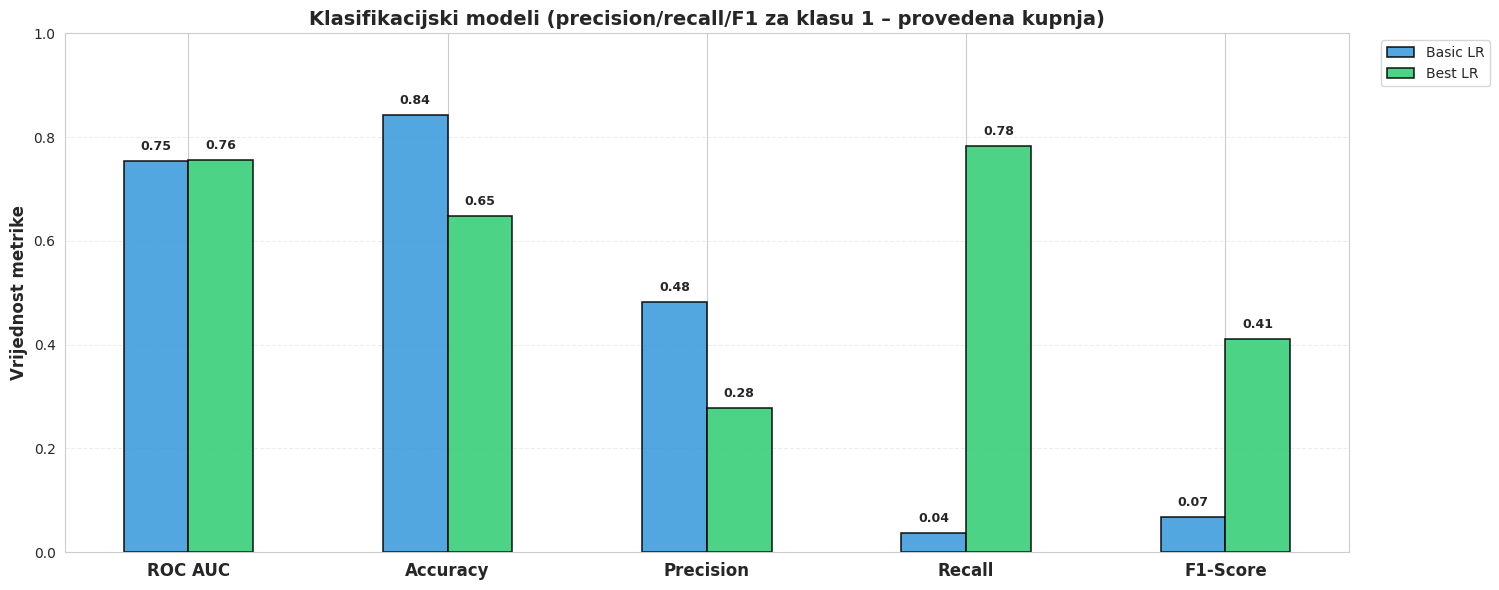

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_cls_recreate = df.drop(columns=["Revenue", "PageValues"])
y_cls_recreate = df["Revenue"].astype(int)


X_train_cls_recreate, X_test_cls_recreate, _, _ = train_test_split(
    X_cls_recreate, y_cls_recreate,
    test_size=0.20,
    random_state=42,
    stratify=y_cls_recreate
)


categorical_cols_recreate = [
    "Month", "VisitorType", "Weekend", "OperatingSystems", "Browser", "Region", "TrafficType"
]
categorical_cols_recreate = [c for c in categorical_cols_recreate if c in X_train_cls_recreate.columns]


scale_cols_recreate = [c for c in X_train_cls_recreate.columns if c not in categorical_cols_recreate]


X_train_enc_recreate = pd.get_dummies(
    X_train_cls_recreate, columns=categorical_cols_recreate, drop_first=True, dtype=int
)
X_test_enc_recreate = pd.get_dummies(
    X_test_cls_recreate, columns=categorical_cols_recreate, drop_first=True, dtype=int
)

X_test_enc_recreate = X_test_enc_recreate.reindex(columns=X_train_enc_recreate.columns, fill_value=0)


scaler_recreate = StandardScaler()


X_train_scaled_recreate = X_train_enc_recreate.copy()
X_test_scaled_recreate = X_test_enc_recreate.copy()

X_train_scaled_recreate[scale_cols_recreate] = scaler_recreate.fit_transform(X_train_enc_recreate[scale_cols_recreate])
X_test_scaled_recreate[scale_cols_recreate] = scaler_recreate.transform(X_test_enc_recreate[scale_cols_recreate])


X_test_scaled = X_test_scaled_recreate


y_pred = log_reg.predict(X_test_scaled)
y_pred_best = best_lr.predict(X_test_scaled)


classification_df = pd.DataFrame([
    {
        "Model": "Basic LR",
        "ROC AUC": float(roc_auc),
        "Accuracy": float(acc),
        "Precision": float(precision_score(y_test_cls, y_pred, pos_label=1)),
        "Recall": float(recall_score(y_test_cls, y_pred, pos_label=1)),
        "F1-Score": float(f1_score(y_test_cls, y_pred, pos_label=1)),
    },
    {
        "Model": "Best LR",
        "ROC AUC": float(roc_auc_best),
        "Accuracy": float(acc_best),
        "Precision": float(precision_score(y_test_cls, y_pred_best, pos_label=1)),
        "Recall": float(recall_score(y_test_cls, y_pred_best, pos_label=1)),
        "F1-Score": float(f1_score(y_test_cls, y_pred_best, pos_label=1)),
    }
])

print("\nTablica rezultata :")
print(classification_df.to_string(index=False))


metrics_plot = ["ROC AUC", "Accuracy", "Precision", "Recall", "F1-Score"]

x = np.arange(len(metrics_plot))
n_models = len(classification_df)
width = min(0.8 / max(n_models, 1), 0.25)

fig, ax = plt.subplots(figsize=(18, 6))

colors = ["#3498db", "#2ecc71"]
legend_handles, legend_labels = [], []

for i, (_, row) in enumerate(classification_df.iterrows()):
    offset = (i - (n_models - 1) / 2) * width
    color = colors[i % len(colors)]
    first_bar = None

    for j, m in enumerate(metrics_plot):
        v = float(row[m])

        bars = ax.bar(
            x[j] + offset, v, width=width,
            color=color, alpha=0.85,
            edgecolor="black", linewidth=1.2
        )

        if first_bar is None:
            first_bar = bars[0]

        ax.text(
            x[j] + offset, v + 0.015,
            f"{v:.2f}",
            ha="center", va="bottom",
            fontsize=9, fontweight="bold"
        )

    legend_handles.append(first_bar)
    legend_labels.append(row["Model"])

ax.set_xticks(x)
ax.set_xticklabels(metrics_plot, fontsize=12, fontweight="bold")
ax.set_ylabel("Vrijednost metrike", fontsize=12, fontweight="bold")
ax.set_title("Klasifikacijski modeli (precision/recall/F1 za klasu 1 – provedena kupnja)", fontsize=14, fontweight="bold")


ax.set_ylim(0, 1.0)
ax.grid(True, axis="y", alpha=0.35, linestyle="--")

ax.legend(legend_handles, legend_labels, loc="upper left",
          bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout(rect=[0, 0, 0.84, 1])
plt.show()